# Victorian-era Data Exploration: 

## Digging into the British Ordinance Survey of 1888-1914 with Python

Analysis done by Jessie Aldridge, May 5, 2025.

Project completed as a final project for HIST 4261: Working with Data at CU Denver, Spring '25.

*Disclaimer*: Generative AI was utilized to help generate some of the code within this project.

---

## Introduction

This project is exploring spatial relationships buried within Ordinance Survey data from around the year 1900, with an emphasis on data showing the impact of the Industrial Revolution. The data within the Ordinance Survey dataset gives us an intimate knowledge of what this country was like at the time, with incredibly detailed enumeration of pre-WWI Britain. The exploration of this data will result in patterns that help show the transformation that the Industrial Revolution had, as well as hinting towards the evolution of our relationship of the land we inhabit.


<div align="center">
  <img
    src="../assets/img/london.jpg"
    width="60%"
    style="border: 2px solid"
    alt="London from the 1900s"
  />
  <figcaption style="font-style: italic">
    Industrializing London during the turn of the 19th century.
  </figcaption>
</div>


The Ordinance Survey is the national mapping agency for Great Britian, dating back to the late 1700s. Like many other modern staples in our governments today, the original purpose of this process was due to military purposes. In 1745, the Duke of Cumberland, along with other British officers, went out to create extensive military maps of the Scottish Highlands in wake of the Jacobite Rebellion. This government-sponsored collection of data dates back over two hundred years, and much of the data can still be accessed today in person at select libraries and collection houses within Britain. The dataset I will be exploring was originally collected, digitized, and organized by a group of over one thousand volunteers, led by researchers from the University of Portsmouth, the GB Historial GIS, the National Library of Scotland, among many other institutions within the UK.

In [55]:
import pandas as pd

In [57]:
gb1900 = pd.read_csv('../data/original/gb1900_gazetteer_complete_july_2018.csv', encoding='utf-16')

/var/folders/35/7877ljzn6nj5tdww9cfrpbz40000gn/T/ipykernel_27134/1535461121.py:1: DtypeWarning:

Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.



In [58]:
gb1900.sample(5)

,pin_id,final_text,nation,local_authority,parish,osgb_east,osgb_north,latitude,longitude,notes
2170432,583369bc2c66dc680e03e5fc,Barren Point Scar,England,Barrow in Furness,NaN,326045.632161,465332.012932,54.078577,-3.131833,NaN
2071777,59119d6f2c66dcf8fa1401df,Old Hushes,England,County Durham,Lunedale,385624.732593,522751.804363,54.599735,-2.224023,NaN
602550,530a065a56475d000800079d,Old Tramways,Wales,Merthyr Tydfil,Troed-y-rhiw,307836.628794,202775.029868,51.716105,-3.335466,NaN
2032493,592183b02c66dc085a030a55,Town's Houses,England,Hambleton,Kirby Wiske,437606.773839,485003.111150,54.259322,-1.424205,NaN
88895,591a58ba2c66dc085a01676d,P,England,Bexley,Bexley (Un-parished),546495.275356,170975.118382,51.418867,0.105411,NaN


In [59]:
gb1900.shape

(2552459, 10)

The .shape function within pandas shows the "shape" of the table of data, otherwise known as the DataFrame. Here, we can see the first number shows this set of data has over 2 and a half million unique rows, which correspond to a unique entry. This is impressive in its own right, as the collection of this data must have been a massive undertaking, but I must break this data into more manageable chunks if we wish to analyse it to any real degree. I looked into the top 300 most common results in the 'final_text' column along with the help of LLMs to generate code which breaks the data into distinct buckets.

In [64]:
# LLM Generated Code #

import pandas as pd, re

# 1. filter out one- or two-letter abbreviations
abbrs = {'F. P.', 'W', 'P', 'F. B.', 'S. P.', 'S. Ps.', 'G. P',
         'B. S.', 'M. S.', 'M. P', 'B. R.', 'B. P.', 'L. B', 'P. O.'}
pat_abbr = re.compile(r'^[A-Z](?:\.\s?)?(?:[A-Z]\.?)?$')

df = (gb1900
      .loc[~(gb1900['final_text'].isin(abbrs) |
             gb1900['final_text'].str.match(pat_abbr))])

# 2. compile your bucket patterns
bucket_patterns = {
    'Hydrology':        r'\b(Spring|Weir|Reservoir|Ford|Waterfall|Dam|Leat|Sluice|Watershed)\b',
    'Extractive':       r'\b(Quarry|Pit|Mine|Shaft|Clay|Chalk|Coal|Lead)\b',
    'Industrial':       r'\b(Mill|Malthouse|Brewery|Works|Factory|Engine House|Smithy|Gasometer|Saw|Brick|Tile|Pottery)\b',
    'Residential':      r'\b(House|Lodge|Farm|Cottage|Barn|Inn)\b',
    'Institutional':    r'\b(Church|Chapel|Vicarage|Rectory|Mission Hall|School|Cemetery|Reading Room)\b',
    'Transport/Infra':  r'\b(Station|Bridge|Ferry|Landing|Road|High Street|Post Office|Quay)\b',
    'Topography':       r'\b(Tumulus|Cairn|Earthwork|Hill|Mount|Arch|Plantation)\b'
}
compiled = {cat: re.compile(pat, re.IGNORECASE) for cat, pat in bucket_patterns.items()}

# 3. helper for bucket assignment
def assign_bucket(txt):
    for cat, rx in compiled.items():
        if rx.search(str(txt)):
            return cat
    return 'Other'

# 4. assign categories without SettingWithCopyWarning
df = df.assign(category=lambda d: d['final_text'].apply(assign_bucket))

In [65]:
df_hydro      = df[df['category'] == 'Hydrology']
df_extractive = df[df['category'] == 'Extractive']
df_industrial = df[df['category'] == 'Industrial']
df_residential= df[df['category'] == 'Residential']
df_institution= df[df['category'] == 'Institutional']
df_transport  = df[df['category'] == 'Transport/Infra']
df_topo       = df[df['category'] == 'Topography']
df_other      = df[df['category'] == 'Other']

In [66]:
df_hydro.sample(5)

,pin_id,final_text,nation,local_authority,parish,osgb_east,osgb_north,latitude,longitude,notes,category
857361,57fff4182c66dcab3d05d292,Waterfall,Scotland,Highland,Bracadale,143265.290520,831190.585943,57.298879,-6.263602,NaN,Hydrology
2100374,592343112c66dc085a039352,Spring,England,Scarborough,Westerdale,466595.918554,507568.242916,54.459140,-0.974221,NaN,Hydrology
540843,52b569dd15d042000d001ae5,Weir,Wales,Bridgend,Maesteg,285217.022602,192457.814247,51.619202,-3.659359,NaN,Hydrology
532731,598ae4302c66dc085a178163,Ford,Wales,Powys,Aberhafesp,306357.891369,294000.801780,52.535790,-3.382008,NaN,Hydrology
2505422,5886b5192c66dc67e2097174,Ford,England,Staffordshire Moorlands,Heathylee,409334.864269,363807.850868,53.171303,-1.861809,NaN,Hydrology


We now have our buckets, as evidenced by this slice of the new df_hydro DataFrame. Now that we have the larger DataFrame broken down, we can analyze specific aspects, specfically the industrial category. Real quick, however, the pie chart below shows the breakdown of the data after we have done our categorization. 

In [15]:
from IPython.display import HTML, IFrame, display

display(
    HTML('<div align="center">'),
    IFrame(src='../assets/html/OS-categories.html', width='100%', height='500', frameborder='0'),
    HTML('<figcaption style="font-style: italic">Ordinance Survey Categories</figcaption></div>')
)


---

## Analysis

This dataset is not just some random assortment of items on a list, rather, it is an accurate snapshot of the landscape of that time period, ripe for exploration. Using the data contained within the "final_text" column, we can break down patterns that arise from this dataset. By clustering these place names into thematic buckets, I will reveal how a geographical pattern emerges, one showing the link between industrial sites and existing features, such as mineral deposits, transport networks, or ocean access, a pattern that reflected the uneven pace that drove the Industrial Revolution.

Interestingly, the "Industrial" category had the smallest share of the values in the pie chart above, however, that does not mean the data is not worth exploring. I would argue that the amount of entries dealing with industrialization show just how fast Britain was industrializing, as this category contains just under 50 thousand features. This scale signifies how much the country was changing at this time, and the charts and maps below will explore the numerical and spatial relationships this data exhibits.

As shown in this bar graph, there were many buildings flagged in the industrial filter that have some industrial use, but were not buildings brought about due to the Industrial Revolution. I am going to narrow down this dataset further to single out these specific buildings. 

In [17]:
from IPython.display import HTML, IFrame, display

display(
    HTML('<div align="center">'),
    IFrame(src='../assets/html/industrial.html', width='100%', height='500', frameborder='0'),
    HTML('<figcaption style="font-style: italic">Industrial buildings breakdown</figcaption></div>')
)


In [19]:
# LLM Generated Code #

import re

# 1. Start from your Industrial subset (from earlier)
df_ind = df[df['category'] == 'Industrial'].copy()

# 2. Define a granular list of power-generation terms
power_terms = [
    r'\bPower Station\b',
    r'\bOil Refinery\b',
    r'\bGas Works\b',
    r'\bGasometer\b',
    r'\bEngine House\b',
    r'\bBoiler House\b',
    r'\bSteam Pump\b',
    r'\bBeam Engine\b',
    r'\bSteam Engine\b',
    r'\bElectric Works\b',
    r'\bHydraulic Engine\b',
    r'\bCoal Power\b'
]
power_rx = re.compile('|'.join(power_terms), flags=re.IGNORECASE)

# 3. Flag each row if it matches any of the power-generation patterns
df_ind = df_ind.assign(
    is_power=lambda d: d['final_text'].str.contains(power_rx, na=False)
)

# 4. Split into a new DataFrame for power-generation sites only
df_power = df_ind[df_ind['is_power']].copy()

# 5. Sanity check
print("Total industrial entries:", len(df_ind))
print("Power-generation entries:",   len(df_power))
print(df_power['final_text'].value_counts())


Total industrial entries: 48436
Power-generation entries: 2762
final_text
Gas Works                                   1344
Gasometer                                    444
Engine House                                 399
gas works                                     99
engine house                                  46
                                            ... 
Gas Works (Morley Corpn.)                      1
Old Mill Gas Works                             1
Calverley & Horsforth Gas Works                1
clayton gas works (Bradford Corporation)       1
Gas Works (Clitheroe Corpn.)                   1
Name: count, Length: 217, dtype: int64


In [19]:
# LLM Generated Code #

import re

# 1. Start from your Industrial subset (from earlier)
df_ind = df[df['category'] == 'Industrial'].copy()

# 2. Define a granular list of power-generation terms
power_terms = [
    r'\bPower Station\b',
    r'\bOil Refinery\b',
    r'\bGas Works\b',
    r'\bGasometer\b',
    r'\bEngine House\b',
    r'\bBoiler House\b',
    r'\bSteam Pump\b',
    r'\bBeam Engine\b',
    r'\bSteam Engine\b',
    r'\bElectric Works\b',
    r'\bHydraulic Engine\b',
    r'\bCoal Power\b'
]
power_rx = re.compile('|'.join(power_terms), flags=re.IGNORECASE)

# 3. Flag each row if it matches any of the power-generation patterns
df_ind = df_ind.assign(
    is_power=lambda d: d['final_text'].str.contains(power_rx, na=False)
)

# 4. Split into a new DataFrame for power-generation sites only
df_power = df_ind[df_ind['is_power']].copy()

# 5. Sanity check
print("Total industrial entries:", len(df_ind))
print("Power-generation entries:",   len(df_power))
print(df_power['final_text'].value_counts())


Total industrial entries: 48436
Power-generation entries: 2762
final_text
Gas Works                                   1344
Gasometer                                    444
Engine House                                 399
gas works                                     99
engine house                                  46
                                            ... 
Gas Works (Morley Corpn.)                      1
Old Mill Gas Works                             1
Calverley & Horsforth Gas Works                1
clayton gas works (Bradford Corporation)       1
Gas Works (Clitheroe Corpn.)                   1
Name: count, Length: 217, dtype: int64


In [20]:
df_power.sample(5)

,pin_id,final_text,nation,local_authority,parish,osgb_east,osgb_north,latitude,longitude,notes,category,is_power
1232329,58c5d0462c66dcf8fa017bb0,Engine House,England,Cornwall,St Stephen-In-Brannel,194496.243771,54835.669461,50.357470,-4.890450,NaN,Industrial,True
288560,592ac6882c66dc085a04e9b2,Highfield Engine House,England,Bradford,Bradford (Un-parished),417168.404347,428796.287688,53.755250,-1.741097,NaN,Industrial,True
1390781,57eae1c72c66dcd15d004d9e,Gasometer,England,West Oxfordshire,Bruern,426490.055854,220491.244298,51.882359,-1.616557,NaN,Industrial,True
1577517,5839ceb12c66dcd5d000451e,Gas Works,England,Mendip,Glastonbury,349542.477528,139135.009027,51.149239,-2.722759,NaN,Industrial,True
200350,58dcfcd52c66dcf8fa0836df,Gasometer (Disused),England,Halton,Halton (Un-parished),349827.412892,384945.348683,53.358991,-2.755328,NaN,Industrial,True


In [21]:
df_power.to_csv('os_power_sites.csv', index=False)

Now, we have a set of data that loosely represents the state of industrial growth in the UK during this time period. This new set of data will be the only data we explore from here on out, and has been written into a CSV file which can be found on the accompanying GitHub repository. Exploring the spatial relationship embedded within this slice of the larger set will require some mapping, so lets get into it!

In [13]:
from IPython.display import HTML, IFrame, display

display(
    HTML('<div align="center">'),
    IFrame(src='../assets/html/power.html', width='100%', height='500', frameborder='0'),
    HTML('<figcaption style="font-style: italic">Power-related buildings breakdown</figcaption></div>')
)


In [24]:
df_power = pd.read_csv('../data/processed/os_power_sites.csv')
df_power.shape

(2762, 12)

The number of entries went from a whopping 2 and a half million to just under three thousand, a number more manageable for dealing with maps.

In [26]:
# LLM Generated Code #

import pandas as pd
import folium
from folium.plugins import HeatMap, MarkerCluster
from IPython.display import display


# 2. Initialize the map centered on the mean location
m = folium.Map(
    location=[df_power['latitude'].mean(), df_power['longitude'].mean()],
    zoom_start=6,
    tiles='CartoDB positron'
)

# 3. Add a heatmap layer (density)
HeatMap(
    data=df_power[['latitude', 'longitude']].values.tolist(),
    radius=15,
    blur=15,
    max_zoom=10
).add_to(m)

# 4. Clustered markers for drill-down
marker_cluster = MarkerCluster(name='Power Sites').add_to(m)
for _, row in df_power.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['final_text']
    ).add_to(marker_cluster)

# 5. Layer control & inline display
folium.LayerControl().add_to(m)
display(m)


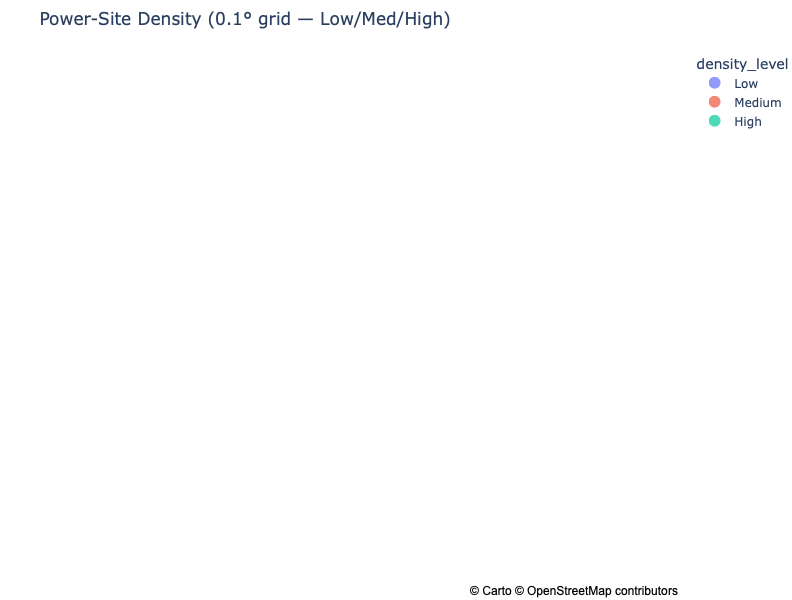

In [71]:
# LLM Generated Code
import plotly.express as px

# 1. Bin points into a 0.1° grid
df_grid = (
    df_power
      .assign(
        latitude  = df_power['latitude'].round(1),
        longitude = df_power['longitude'].round(1)
      )
      .groupby(['latitude','longitude'])
      .size()
      .reset_index(name='count')
)

# 2. Drop noise: only keep cells with ≥2 sites
df_grid = df_grid[df_grid['count'] > 1]

# 3. Compute percentile rank and cut into three levels
df_grid['pct_rank'] = df_grid['count'].rank(pct=True)
df_grid['density_level'] = pd.cut(
    df_grid['pct_rank'],
    bins=[0, 0.33, 0.66, 1.0],
    labels=['Low','Medium','High'],
    include_lowest=True
)
df_grid.drop(columns='pct_rank', inplace=True)

# 4. Bubble‐map with discrete colors
fig = px.scatter_mapbox(
    df_grid,
    lat='latitude',
    lon='longitude',
    size='count',
    size_max=30,
    color='density_level',
    color_discrete_sequence=px.colors.qualitative.Plotly,
    category_orders={'density_level':['Low','Medium','High']},
    zoom=5,
    mapbox_style='carto-positron',
    title='Power‐Site Density (0.1° grid — Low/Med/High)',
    width=800,
    height=600
)

fig.update_layout(margin=dict(l=0, r=0, t=50, b=0))
fig.show()


The two of these maps do a good job at helping explain the scale of Britain's industrialization, which was incredibly widespread, all with little centralization. The largest geographic patterns noticable immediately are how much of Southern England and the Midlands were well covered by these power-related buildings, as well as the noticable pattern of data points hugging the coastline. With their imperial ambitions spread across the globe, it makes sense the power of the British colonial engine came from it's growing coastal population centers. Although the patterns present within the geographic data can help explain some larger trends present in British history, we have to keep in mind that the Ordnance Survey tended to record sites of military and commercial priority, so we are looking at a map of power as much as a map of people’s everyday lives.

---

## Conclusion

When we work with the Ordnance Survey data we must recognise that every decision by the original mapmakers reflects a set of priorities and biases that shape what appears and what vanishes. Only features judged important by military or administrative authorities made it onto the name-books, leaving out countless local landmarks and vernacular place-names in Gaelic or Welsh. Abbreviations, inconsistent spellings and shifts between editions introduce ambiguities in both meaning and location. As a result, when we sort and analyse these labels we face gaps that are not gaps in history but gaps in recording. We need to treat absence on the map as a caution rather than proof, to document carefully how we classify and group each entry and to bring in community memories and archival sources wherever possible. By doing so we accept that our findings will always carry uncertainty, acknowledge the map’s blind spots and use its power responsibly without pretending it tells the whole story.

<div align="center">
  <img
    src="../assets/img/pollution.jpg"
    width="60%"
    style="border: 2px solid"
    alt="1900s Factory"
  />
  <figcaption style="font-style: italic">
    Factories polluting the air, land, and water.
  </figcaption>
</div>

[Project repository can be accessed here](https://github.com/jwaldridgeIV/research-project)

### Bibliography: 

Dataset: 
- https://www.visionofbritain.org.uk/data/#tabgb1900

Scholarly articles:
- https://www.tandfonline.com/doi/full/10.1080/14662035.2018.1429717#d1e100
- https://academic.oup.com/jvc/article/26/2/284/6232245
- https://muse.jhu.edu/pub/133/article/546194/summary

Pictures: 
- https://www.standard.co.uk/news/london/stunning-images-show-iconic-london-landmarks-through-the-1900s-a3930331.html
- https://theconversation.com/air-pollution-in-victorian-era-britain-its-effects-on-health-now-revealed-87208